In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def generate_particles(N, box_length=18, min_distance=3, temperature=100):
    # Generate positions
    positions = np.zeros((N, 3))
    num_attempts = 0
    for i in range(N):
        while True:
            new_position = np.random.uniform(low=0, high=box_length, size=3)
            if i == 0:
                break
            min_dist = np.min(np.linalg.norm(positions[:i] - new_position, axis=1))
            if min_dist >= min_distance:
                break
            num_attempts += 1
            if num_attempts > 1000:
                raise ValueError("Could not generate positions with given constraints.")
        positions[i] = new_position
    
    # Generate velocities from Maxwell-Boltzmann distribution
    m = 1  # mass of particles
    k = 1  # Boltzmann constant
    std_dev = np.sqrt(k * temperature / m)
    velocities = np.random.normal(loc=0, scale=std_dev, size=(N, 3))
    
    return positions, velocities

In [3]:
N = 108  # Number of particles
positions, velocities = generate_particles(N)
print(positions)
# print(velocities)

# with open("abc.xyz", "a") as file:
#     file.write("108\n")
#     file.write("WOW\n")
#     it = 0
#     for k in positions:
#         file.write("Ar" + str(it) + " " + str(k[0]) + " " + str(k[1]) + " " + str(k[2]) + "\n")
#         it += 1

[[1.67942585e+01 4.85177975e+00 1.51603001e+01]
 [5.67985270e+00 7.40653719e+00 1.30425271e+01]
 [6.16384762e+00 8.38626058e+00 7.45387152e+00]
 [1.26669445e+01 9.62183506e+00 9.36472918e+00]
 [1.06940628e+01 3.52529374e+00 3.42264657e+00]
 [1.45629019e+01 1.27535429e+01 6.24243606e+00]
 [1.27484608e+01 1.76064017e+01 1.78627758e-01]
 [6.31961343e+00 1.68198428e+01 5.01638119e+00]
 [8.26155230e-01 1.02245893e+01 4.86584049e+00]
 [1.53270929e+00 3.50540041e+00 1.47229773e+01]
 [1.04736707e+01 1.54122661e+01 2.83544395e+00]
 [2.54138219e+00 4.62557811e+00 4.91305453e+00]
 [8.95488846e+00 7.68081361e+00 1.01841503e+01]
 [1.17025855e+01 7.91711389e+00 1.53385647e+01]
 [4.34537910e+00 1.45699243e+01 7.56551802e+00]
 [1.36890171e+01 1.06281435e+01 1.51409216e+01]
 [9.15892528e+00 1.58023402e+01 1.41135168e+01]
 [1.65327377e+01 9.94951376e+00 1.72965323e+01]
 [1.25429138e+01 8.93600653e+00 1.48177190e+00]
 [8.45054324e+00 1.46549420e+01 7.40761154e+00]
 [4.24058513e-01 1.57909952e+01 1.897403

In [4]:
delta_matrix = positions[:, np.newaxis] - positions
mindist = 0.3
delta_matrix[delta_matrix < mindist] = mindist
# print(delta_matrix)

In [5]:
distance_matrix = np.sum(np.square(delta_matrix), axis=-1)
# print(distance_matrix)

In [6]:
def calculate_grad(pos, delta, dist, eps = 1, sig = 3.4):
    grad = []
    for i in range(len(pos)):
        for d in range(3):
            U = 0
            for j in range(len(pos)):
                if j != i:
                    U += (1/dist[i,j]**8 - 2 * sig**6 / dist[i,j]**14) * (delta_matrix[i, j, d])
            U *= 24 * eps * sig**6
            grad.append(U)
    gradients = np.array(grad).reshape(len(pos), 3)
    return gradients

In [7]:
def calculate_pot(dist, eps = 1, sig = 3.4):
    U = 0
    global N
    for i in range(N):
        for j in range(i+1,N):
            U += 4 * eps * (sig**12 / dist[i,j]**12 - sig**6 / dist[i,j]**6)
    return U

In [8]:
def main_loop(pos, delta, dis, max_iter = 2000, beta = 1, fac = 1):
    pots = [calculate_pot(dis)]
    for i in tqdm(range(max_iter)):
        part = np.random.randint([108,3])
        pos1 = np.copy(pos)
        pos1[part[0], part[1]] += fac * (np.random.rand() - 0.5)
        delta = pos1[:, np.newaxis] - pos1
        delta[delta < mindist] = mindist
        dis = np.sum(np.square(delta), axis=-1)
        pottt = calculate_pot(dis)
        if pottt - pots[-1] < 0:
            pots.append(pottt)
            pos = pos1
        elif np.random.rand() < np.exp(-1 * beta * (pottt - pots[-1])):
            pots.append(pottt)
            pos = pos1
    return pots

In [9]:
pots = main_loop(positions, delta_matrix, distance_matrix)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 166.66it/s]


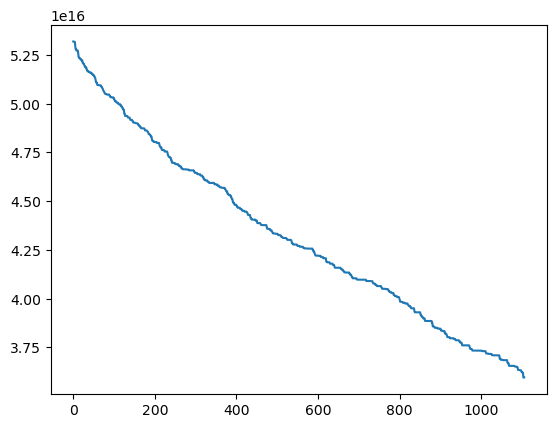

In [10]:
plt.plot(pots[1:])
plt.show()